<a href="https://colab.research.google.com/github/musimarusan/Era_Estimation/blob/main/Era_Estimation_LightGBM_binary_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code should be run in Google Colaaboratory.

In [1]:
!pip install plot_confusion_matrix
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=28ad70ed851631987e4081f9bf9b0346f81965ea862e92c24692fb841cf638a9
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [2]:
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, f1_score, accuracy_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ignore warnings
warnings.simplefilter('ignore')

データファイルの読み込み及び学習に使用する特徴量の決定

In [5]:
INFILE='/content/drive/MyDrive/TumulusAnalysis/data/raw/AnalysisWorkFile.csv'
BINFILE='/content/drive/MyDrive/TumulusAnalysis/data/interm/train.bin'

df = pd.read_csv(INFILE,)
df['ID']=df['Name'] + '_' + df['Old_Prefecture']

usedColumns = ['ID', 'Period', 'lon', 'lat', 'dir', 'elev', 'rel_elev', 'tot_length', 'Length', 'R_diameter', 'R_height', 'r_height', 'F_width', 'F_length', 'F_height', 'N_width', 'alpha', 'beta']
# usedColumns = ['ID', 'lon', 'lat', 'dir', 'elev', 'rel_elev', 'Length', 'alpha', 'beta','Period']
# usedColumns = ['ID', 'lon', 'lat', 'Length', 'alpha', 'beta','Period']
# usedColumns = ['ID', 'alpha', 'beta','Period']

df = df[usedColumns]
df = df.replace(-999.0, np.nan)
df = df.set_index('ID')
# df['Period'] = df['Period'].replace(0,np.nan)

# print('Totlal number of tumulus:', len(df))
# print('Condition A:', (df['alpha'].notnull() & df['beta'].notnull() ).sum())
# print('Condition B:',  df['Period'].notnull().sum())
# print('Condition C:', (df['Period'].notnull() & df['alpha'].notnull() & df['beta'].notnull() ).sum())


データを学習用データと推論用データに分割

In [6]:
# df_base = df.dropna(axis=0)
df_base = df
df_train = df_base[df_base['Period'] != 0.0] # 教師データ：目的変数（編年）が存在する

df_test  = df_base[df_base['Period'] == 0.0] # テストデータ
df_test  = df_test.drop('Period', axis=1)

df_label = df_train.pop('Period')

df_train

,lon,lat,dir,elev,rel_elev,tot_length,Length,R_diameter,R_height,r_height,F_width,F_length,F_height,N_width,alpha,beta
ID,,,,,,,,,,,,,,,,
布野台3号墳_下総,140.628342,35.832206,263.0,49.0,44.0,NaN,28.0,16.5,NaN,NaN,8.0,10.4,NaN,NaN,0.485,0.630
三之分目大塚山古墳_下総,140.581739,35.878695,134.0,4.0,0.0,NaN,123.0,68.0,9.5,19.0,62.0,54.0,7.5,36.0,0.912,0.794
富田1号墳_下総,140.585671,35.874370,150.0,5.0,0.0,NaN,39.0,20.0,3.0,NaN,21.0,NaN,2.5,NaN,1.050,NaN
富田2号墳_下総,140.589302,35.872557,135.0,4.0,0.0,NaN,48.0,28.0,4.5,NaN,32.0,NaN,4.5,NaN,1.143,NaN
富田3号墳_下総,140.590992,35.871879,135.0,4.0,0.0,NaN,41.2,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
太子堂塚古墳_上野,138.864339,36.255132,219.0,185.0,0.0,NaN,57.6,NaN,10.5,NaN,59.0,NaN,7.5,NaN,NaN,NaN
堂山稲荷古墳_上野,138.861598,36.250313,224.0,185.0,0.0,NaN,47.0,28.0,5.5,NaN,36.3,NaN,4.5,NaN,1.296,NaN
北山茶臼山西古墳_上野,138.868368,36.237229,157.5,254.0,1.0,33.6,28.0,17.7,1.1,NaN,16.2,10.3,NaN,4.1,0.915,0.582


各特徴量の学習用データにおける欠損状況の確認

In [7]:
print('train:',len(df_train))
print('test:',len(df_test))
print(df_train.isnull().sum())

train: 520
test: 1444
lon             0
lat             0
dir            18
elev           16
rel_elev       38
tot_length    412
Length          8
R_diameter     61
R_height       92
r_height      423
F_width        96
F_length      167
F_height      167
N_width       284
alpha         101
beta          169
dtype: int64


編年が決定されている墳丘の編年別基数の確認

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[10, 26, 43, 48, 22, 8, 27, 51, 69, 216]


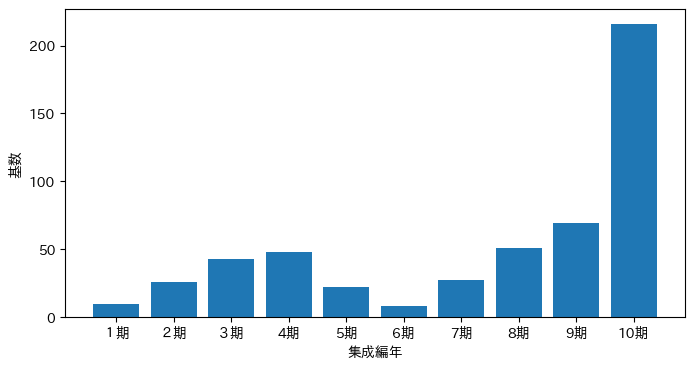

In [8]:
plt.figure(figsize=(8, 4))
df_label = df_label.reset_index()

peri = []
bar_counts = []
for ii in range(1,11):
  count = len(df_label[df_label['Period']==ii])
  bar_counts.append(count)
  peri.append(ii)

print(peri)
print(bar_counts)
plt.bar(peri, bar_counts)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ["１期", "２期", "３期", "4期", "5期", "6期", "7期", "8期", "9期", "10期"])
ｐｌｔ.xlabel('集成編年')
plt.ylabel('基数')

df_label = df_label.set_index('ID')


学習データを４フォールドで学習:テスト=8:2に分割する

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_label, stratify=df_label, random_state=42, train_size=0.8)
kf = KFold(n_splits=4, random_state=42, shuffle=True)
print(len(X_train), len(X_test), len(y_train), len(y_test))

416 104 416 104


機械学習の実施

In [10]:
params = {'objective': 'multiclass', 'num_class': 11, 'random_state': 42, 'num_iterations': 1000, }

valid_scores = []
f_one_scores = []
cl_reports = []
models = []

for fold, (train_indices, valid_indices) in enumerate(kf.split(X_train)):
  X_tra, X_val = X_train.iloc[train_indices], X_train.iloc[valid_indices]
  y_tra, y_val = y_train.iloc[train_indices], y_train.iloc[valid_indices]
  train_set = lgb.Dataset(X_tra, y_tra)
  valid_set = lgb.Dataset(X_val, y_val)
  model = lgb.train(
      params,
      train_set,
      valid_sets=valid_set,
      callbacks=[
          lgb.early_stopping(
          stopping_rounds=100,
          verbose=True
          ), # early_stopping用コールバック関数
          lgb.log_evaluation(1) # この数字を1にすると学習時のスコア推移がコマンドライン表示される
        ] # コマンドライン出力用コールバック関数
  )
  valid_pred = model.predict(X_val)

  X_val['label'] = y_val


  valid_pred = [np.argmax(line) for line in valid_pred]
  mae_score = mean_absolute_error(y_val, valid_pred)
  f_one_score = f1_score(y_val, valid_pred, average='micro')
  print(f"fold: {fold}, MAE: {mae_score}")
  print(f"fold: {fold}, f1: {f_one_score}")
  cl_report = classification_report(y_val, valid_pred)
  valid_scores.append(mae_score)
  f_one_scores.append(f_one_score)
  cl_reports.append(cl_report)
  models.append(model)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 312, number of used features: 16
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -4.133565
[LightGBM] [Info] Start training from score -2.970414
[LightGBM] [Info] Start training from score -2.607509
[LightGBM] [Info] Start training from score -2.309016
[LightGBM] [Info] Start training from score -3.178054
[LightGBM] [Info] Start training from score -4.356709
[LightGBM] [Info] Start training from score -3.034953
[LightGBM] [Info] Start training from score -2.187655
[LightGBM] [Info] Start training from score -2.105417
[LightGBM] [Info] Start training from score -0.860201
[LightGBM] [Warning] No further splits with positive ga

foldごとの全体スコアの確認

In [11]:
print(valid_scores)
print(f_one_scores)

[2.451923076923077, 2.2788461538461537, 1.7980769230769231, 2.076923076923077]
[0.375, 0.40384615384615385, 0.5, 0.41346153846153844]


foldごとの個別スコアの確認

In [14]:
  for cl_report in cl_reports:
    print(cl_report)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.33      0.20      0.25         5
           3       0.00      0.00      0.00        11
           4       0.29      0.29      0.29         7
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        17
          10       0.42      0.88      0.57        41

    accuracy                           0.38       104
   macro avg       0.10      0.14      0.11       104
weighted avg       0.20      0.38      0.26       104

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00        11
           4       0.50 

foldごとの特徴量重要度の確認

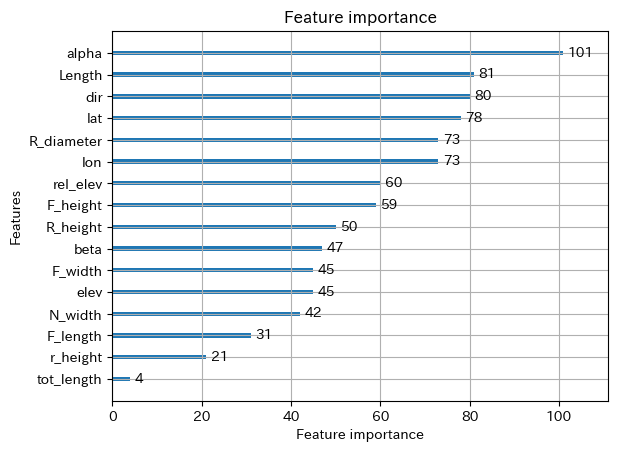

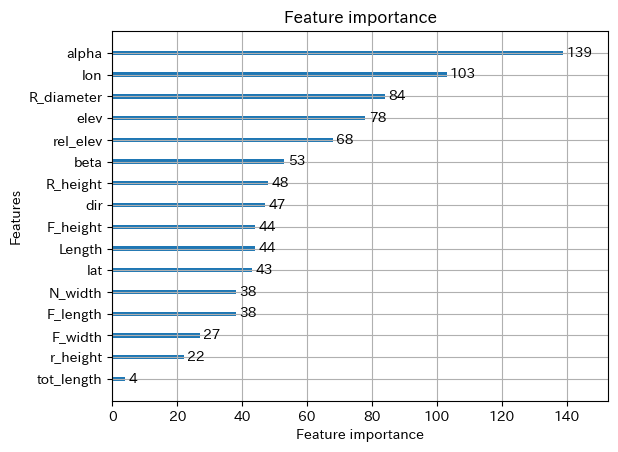

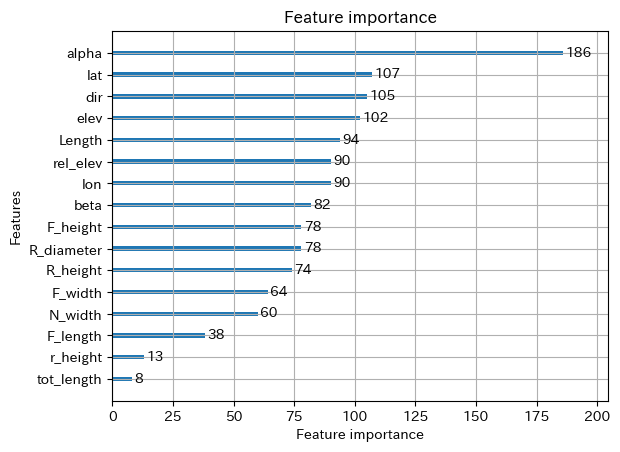

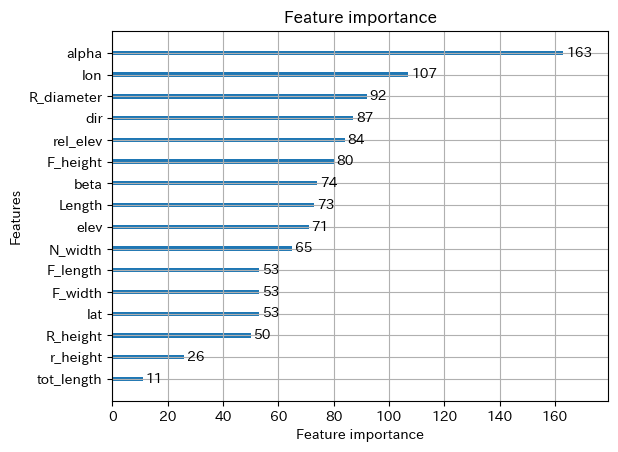

In [13]:
for mod in models:
  lgb.plot_importance(mod)
  plt.show()
